#Project 8
Ον/μο: Μαρία Καρλάκη ΑΕΜ: 244

Ξεσυμπίεση δεδομένων

In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: dataset/Beagle/Beagle_1.jpg  
  inflating: dataset/Beagle/Beagle_10.jpg  
  inflating: dataset/Beagle/Beagle_100.jpg  
  inflating: dataset/Beagle/Beagle_11.jpg  
  inflating: dataset/Beagle/Beagle_12.jpg  
  inflating: dataset/Beagle/Beagle_13.jpg  
  inflating: dataset/Beagle/Beagle_14.jpg  
  inflating: dataset/Beagle/Beagle_15.jpg  
  inflating: dataset/Beagle/Beagle_16.jpg  
  inflating: dataset/Beagle/Beagle_17.jpg  
  inflating: dataset/Beagle/Beagle_18.jpg  
  inflating: dataset/Beagle/Beagle_19.jpg  
  inflating: dataset/Beagle/Beagle_2.jpg  
  inflating: dataset/Beagle/Beagle_20.jpg  
  inflating: dataset/Beagle/Beagle_21.jpg  
  inflating: dataset/Beagle/Beagle_22.jpg  
  inflating: dataset/Beagle/Beagle_23.jpg  
  inflating: dataset/Beagle/Beagle_24.jpg  
  inflating: dataset/Beagle/Beagle_25.jpg  
  inflating: dataset/Beagle/Beagle_26.jpg  
  inflating: dataset/Beagle/Beagle_27.jpg  
  inflating: dataset/Beagle/Beagle_28.jpg  
  inflating

Φόρτωση Βιβλιοθηκών

In [3]:
import os
import PIL
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas
import tensorflow as tf
from sklearn.model_selection import train_test_split

Ορισμός του μεγέθους και εύρεση των κλάσεων

In [4]:
image_size = (64, 64)
class_names = sorted(os.listdir('dataset'))
class_ids = {label: i for i, label in enumerate(class_names)}
class_ids

{'Beagle': 0,
 'Boxer': 1,
 'Bulldog': 2,
 'Dachshund': 3,
 'German_Shepherd': 4,
 'Golden_Retriever': 5,
 'Labrador_Retriever': 6,
 'Poodle': 7,
 'Rottweiler': 8,
 'Yorkshire_Terrier': 9}

Προεπεξεργασία των δεδομένων

In [5]:
inputs = []
targets = []
for label in class_names:
    for filename in os.listdir(f'dataset/{label}'):
        filepath = f'dataset/{label}/{filename}'
        img = PIL.Image.open(filepath).convert('RGB').resize(image_size)
        inputs.append(img)
        targets.append(class_ids[label])
inputs = np.float32(inputs)
targets = np.int32(targets)

inputs.shape, targets.shape

((967, 64, 64, 3), (967,))

Διάταξη των στόχων

<BarContainer object of 10 artists>

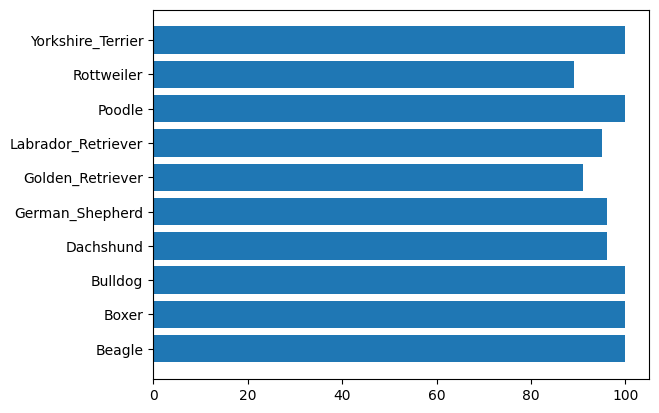

In [6]:
target_counts = np.unique(targets, return_counts=True)
plt.barh(class_names, target_counts[1])

Διαχωρισμός Δεδομένων σε Σύνολα Εκπαίδευσης και Ελέγχου

In [7]:
seed = 0

tf.random.set_seed(seed=seed)
np.random.seed(seed=seed)
random.seed(seed)
test_size = 0.3
stratify = [targets.shape]

x_train, x_test, y_train, y_test = train_test_split(
    inputs,
    targets,
    test_size=0.3,
    stratify=targets,
    random_state=seed
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((676, 64, 64, 3), (676,), (291, 64, 64, 3), (291,))

Κανονικοποίηση Εισόδων και One-Hot Κωδικοποίηση Στόχων

In [8]:
x_train /= 255.0
x_test /= 255.0
y_train = np.eye(len(class_names))[y_train]
y_test = np.eye(len(class_names))[y_test]

y_train.shape, y_test.shape

((676, 10), (291, 10))

Δημιουργία του MLP

In [9]:
input_size = x_train.shape[1:]
output_size = len(class_names)

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='MLP')
mlp.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,794 (6.07 MB)

 Trainable params: 1,590,794 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

Εκπαίδευση του Μοντέλου

In [10]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
mlp.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 30

history = mlp.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1114 - loss: 3.4492 - val_accuracy: 0.2405 - val_loss: 2.3407
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3290 - loss: 2.1139 - val_accuracy: 0.3058 - val_loss: 1.8775
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4222 - loss: 1.7414 - val_accuracy: 0.3608 - val_loss: 1.7471
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5496 - loss: 1.5159 - val_accuracy: 0.5223 - val_loss: 1.4746
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6102 - loss: 1.2736 - val_accuracy: 0.4089 - val_loss: 1.5301
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5927 - loss: 1.2016 - val_accuracy: 0.3780 - val_loss: 1.7180
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6538 - loss: 1.1371 - val_accuracy: 0.5601 - val_loss: 1.2756
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7194 - loss: 0.9733 - val_accuracy: 0.5361 - v

Οπτικοποίηση του Ιστορικού Απώλειας και Ακρίβειας του MLP

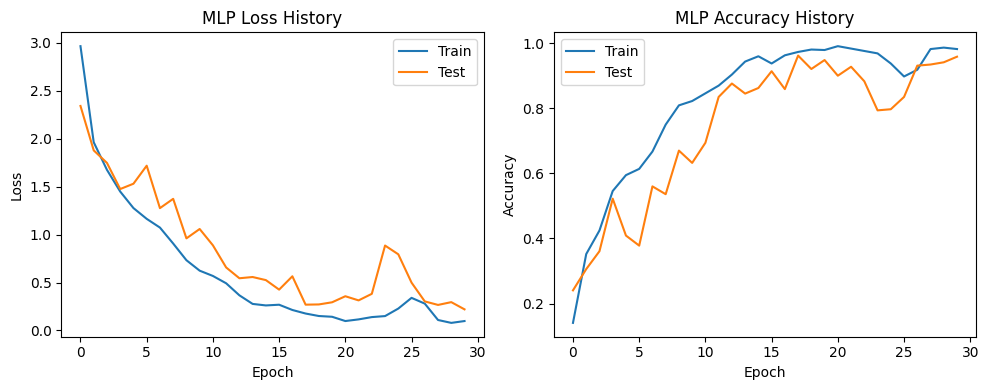

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Test')
axes[0].set_title('MLP Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Test')
axes[1].set_title('MLP Accuracy History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Δημιουργία CNN

In [12]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', use_bias=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', use_bias=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN')
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,298 (13.18 MB)

 Trainable params: 3,456,298 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

Εκπαίδευση του CNN

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.1252 - loss: 2.4610 - val_accuracy: 0.4055 - val_loss: 2.1832
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.4168 - loss: 2.0070 - val_accuracy: 0.5120 - val_loss: 1.6084
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6222 - loss: 1.2607 - val_accuracy: 0.6392 - val_loss: 1.0003
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.8544 - loss: 0.5910 - val_accuracy: 0.8763 - val_loss: 0.3914
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9515 - loss: 0.2708 - val_accuracy: 0.9759 - val_loss: 0.1758
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9941 - loss: 0.0682 - val_accuracy: 0.9759 - val_loss: 0.1144
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9949 - loss: 0.0286 - val_accuracy: 0.9759 - val_loss: 0.1156
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.

Οπτικοποίηση του Ιστορικού Απώλειας και Ακρίβειας του CNN

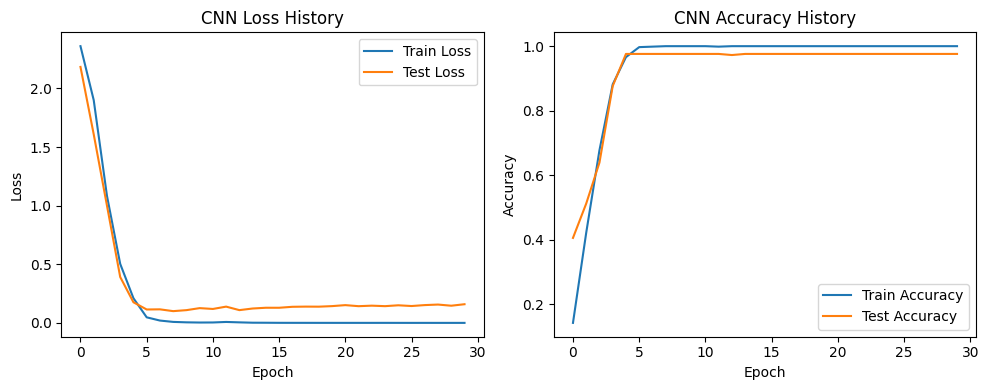

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history_cnn.history['loss'], label='Train Loss')
axes[0].plot(history_cnn.history['val_loss'], label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Loss History')
axes[0].legend()

axes[1].plot(history_cnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_cnn.history['val_accuracy'], label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Accuracy History')
axes[1].legend()

plt.tight_layout()
plt.show()

Αξιολόγηση και σύγκριση των MLP και CNN

In [15]:
mlp_loss, mlp_acc = mlp.evaluate(x_test, y_test, verbose=0)
cnn_loss, cnn_acc = cnn.evaluate(x_test, y_test, verbose=0)

print("MLP  test accuracy:", mlp_acc)
print("CNN  test accuracy:", cnn_acc)

MLP  test accuracy: 0.9587628841400146
CNN  test accuracy: 0.975944995880127


Σύγκριση των Καλύτερων Επιδόσεων των Μοντέλων

In [16]:
max_mlp_val_acc = max(history.history['val_accuracy'])
min_mlp_val_loss = min(history.history['val_loss'])

max_cnn_val_acc = max(history_cnn.history['val_accuracy'])
min_cnn_val_loss = min(history_cnn.history['val_loss'])
print("MLP  - max validation accuracy:", max_mlp_val_acc)
print("MLP  - min validation loss:    ", min_mlp_val_loss)

print("CNN  - max validation accuracy:", max_cnn_val_acc)
print("CNN  - min validation loss:    ", min_cnn_val_loss)

MLP  - max validation accuracy: 0.962199330329895
MLP  - min validation loss:     0.220373272895813
CNN  - max validation accuracy: 0.975944995880127
CNN  - min validation loss:     0.10030360519886017


Με βάση τα αποτελέσματα το CNN αποδίδει καλύτερα από το MLP. Συγκεκριμένα το CNN πέτυχε υψηλότερη ακρίβεια στο test set (0.9759) σε σύγκριση με το MLP (0.9588), γεγονός που δείχνει ότι κάνει πιο σωστές προβλέψεις σε δεδομένα που δεν έχει δει κατά την εκπαίδευση. Επιπλέον η μέγιστη ακρίβεια επικύρωσης του CNN είναι μεγαλύτερη και το σφάλμα επικύρωσης σημαντικά χαμηλότερο, κάτι που υποδηλώνει καλύτερη σύγκλιση και πιο αξιόπιστες προβλέψεις. Από τα διαγράμματα loss και accuracy παρατηρείται ότι το CNN έχει πιο σταθερή συμπεριφορά κατά την εκπαίδευση, με μικρότερη διαφορά μεταξύ του train και του test επίδοσης, ενώ το MLP εμφανίζει μεγαλύτερες διακυμάνσεις και ενδείξεις overfitting. Επομένως με βάση τόσο τα αριθμητικά αποτελέσματα όσο και τα διαγράμματα, το CNN γενικεύει καλύτερα και αποτελεί το πιο αποδοτικό μοντέλο για το συγκεκριμένο πρόβλημα.

CNN με Batch Normalization

In [17]:
cnn_bn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),

    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax')
], name='CNN_with_BatchNorm')

cnn_bn.summary()


Model: "CNN_with_BatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,554 (13.19 MB)

 Trainable params: 3,456,426 (13.19 MB)

 Non-trainable params: 128 (512.00 B)

Εκπαίδευση του νέου μοντέλου

In [19]:
cnn_bn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn_bn = cnn_bn.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32
)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.4267 - loss: 4.1193 - val_accuracy: 0.1546 - val_loss: 2.5068
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9696 - loss: 0.0629 - val_accuracy: 0.1615 - val_loss: 2.5174
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.1512 - val_loss: 2.8372
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 3.3612e-04 - val_accuracy: 0.1856 - val_loss: 3.1774
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 1.0000 - loss: 2.1503e-04 - val_accuracy: 0.1890 - val_loss: 3.4921
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.6280e-04 - val_accuracy: 0.1787 - val_loss: 3.7652
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 1.3316e-04 - val_accuracy: 0.1890 - val_loss: 3.9843
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 1.0000 - loss: 1.1275e-0

Οπτικοποίηση του νέου μοντέλου

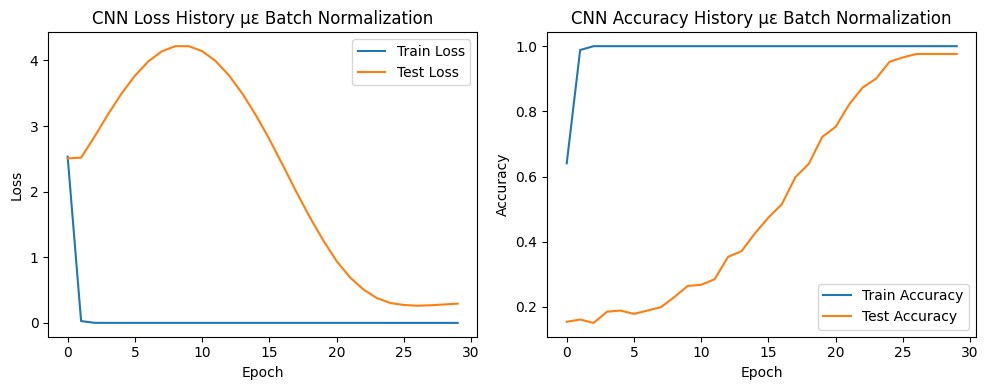

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history_cnn_bn.history['loss'], label='Train Loss')
axes[0].plot(history_cnn_bn.history['val_loss'], label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Loss History με Batch Normalization')
axes[0].legend()

axes[1].plot(history_cnn_bn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_cnn_bn.history['val_accuracy'], label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Accuracy History με Batch Normalization')
axes[1].legend()

plt.tight_layout()
plt.show()

Με την εφαρμογή της τεχνικής Batch Normalization στο CNN παρατηρείται ότι το μοντέλο μαθαίνει πολύ γρήγορα τα δεδομένα εκπαίδευσης, ενώ η απόδοση στο validation set βελτιώνεται πιο αργά αλλά σταθερά. Από τα διαγράμματα accuracy φαίνεται ότι το validation accuracy αυξάνεται συνεχώς και στο τέλος φτάνει σε πολύ υψηλή τιμή, γεγονός που δείχνει καλή γενίκευση.